# **Movie Recommendation System**

Different approaches to building a movie recommendation system are explored, based on movie plots and genres. The work aims to understand the strengths and weaknesses of various recommendation techniques in order to provide meaningful suggestions for users. Three primary models were implemented and evaluated:

1. **Content-based Recommendations using Cosine Similarity**: This model relies solely on the text of movie plot summaries to find similarities between films. While effective for finding basic matches, this method has limitations in its ability to capture deeper thematic or emotional connections.
   
2. **Hybrid Content-based Recommendations using Self-Organizing Map (SOM) with K-Means Clustering**: We utilized a SOM to cluster movies based on their genres and plot features, followed by k-means to generate recommendations. This approach provides a more structured understanding of the relationships between films, offering recommendations that capture both genre and thematic elements.

3. **Hybrid Content-based Recommendations using Graph Neural Network (GNN) with Cosine Similarity**: The GNN model was trained on both plot summaries and genre data, aiming to capture more complex relationships between movies. This model has proven to be the most effective in providing recommendations that are thematically consistent and emotionally resonant.

In [ ]:
!pip install --upgrade somoclu

In [ ]:
!pip install --upgrade torch_geometric

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import nltk
from nltk.corpus import stopwords, names
from somoclu import Somoclu

In [ ]:
# downloading nltk stopwords
nltk.download("stopwords")

# downloading nltk names
nltk.download('names')

## Functions for Plotting

In [ ]:
def barplot(metric_lst, xlabels="", ylabel="", title=""):
    """
    Produces a barplot with one bar per section (with value on top of each bar).
    """
    fig, ax = plt.subplots()
    bars = ax.bar(np.arange(len(metric_lst)), metric_lst, zorder=3)

    # setting labels and title
    ax.set_xticks(np.arange(len(metric_lst)))
    ax.set_xticklabels(xlabels, rotation=50, ha="right")
    ax.set_title(title)
    plt.ylabel(ylabel)

    # annotating bars with the movie count
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1.5),
                    textcoords="offset points",
                    ha="center", va="bottom", zorder=3)
    plt.grid(zorder=0)
    plt.show()


def simpleplot(metric_lst, x_values_lst, labels=[], xlabel="", ylabel="", title=""):
    """
    Produces a standard plot with multiple lines.
    """
    color_lst = ["b", "g", "r", "c", "m", "y", "salmon", "violet"]
    marker_lst = ["o", "^", "s", ">", "<", "v", "*", "d"]

    plt.figure(figsize=(10, 6))

    for i, y_values_lst in enumerate(metric_lst):
        if len(labels) == 0:
            plt.plot(x_values_lst,
                     y_values_lst,
                     color=color_lst[i],
                     marker=marker_lst[i])
        else:
            plt.plot(x_values_lst,
                     y_values_lst,
                     label=labels[i],
                     color=color_lst[i],
                     marker=marker_lst[i])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if len(labels) != 0:
        plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_enhanced_umatrix(som):
    """
    Generates an enhanced U-Matrix Heatmap.
    """
    # creating a U-Matrix with a heatmap overlay
    plt.figure(figsize=(10, 8))
    plt.imshow(som.umatrix, cmap='viridis', interpolation='none')
    plt.colorbar(label='Distance')
    plt.title('U-Matrix Heatmap with Best Matches')

    # overlaying the best matches
    for neuron in som.bmus:
        plt.scatter(neuron[0], neuron[1], color='red', marker='x')

    plt.show()


def plot_som_clusters(clustered_neurons, grid_size=(30, 30)):
    """
    Plotting the clusters of a SOM.
    """
    # defining a list of colors for the clusters
    color_lst = ["w", "b", "g", "r", "c", "m", "y", "salmon", "chocolate", "violet", "black", "gold",
                 "silver", "lime", "orange", "brown", "darkred", "tan", "rosybrown", "skyblue",
                 "purple", "midnightblue", "seagreen", "pink", "hotpink", "teal"]
    M = len(color_lst)

    # scatter plotting each neuron in the SOM grid (color-coded by its cluster)
    plt.figure()
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            plt.scatter(i, j, c=color_lst[int(clustered_neurons[i][j] % M)])

    plt.title("SOM Grid with Cluster Assignments")
    plt.gca().invert_yaxis()
    plt.show()

## Functions for Data Inspection

In [ ]:
def clean_genres(genre_string):
    """
    Cleans up the 'genres' column by fixing any improperly formatted entries.
    """
    if pd.notnull(genre_string):
        # removing any stray characters and extra spaces
        cleaned = re.sub(r'[^a-zA-Z0-9,: ]', '', genre_string)
        return [genre.split(":")[1] for genre in cleaned.split(",") if ":" in genre]
    return []


def check_NaN_values(df_features):
    """
    Checks if data contains NaN values.
    """
    if df_features.isnull().values.any():
        print("Data contains NaN values.")
    else:
        print("Data does not contain NaN values.")


def check_balance(df_features):
    """
    Checks size and balance of dataset.
    """
    n_samples = df_features.shape[0]
    n_features = len(df_features.columns)

    print("Number of samples:", n_samples)
    print("Number of features:", n_features)

## Functions for Statistics

In [ ]:
def print_movie_statistics(df):
    """
    Prints statistics for movies and their plots.
    """
    df["num_categories"] = df["genres"].apply(len)
    df["summary_length"] = df["plot_summary"].apply(len)

    # number of unique genres
    num_genres = len(set([genre for sublist in df["genres"] for genre in sublist]))

    # average number of genres per movie
    avg_categories = df["num_categories"].mean()

    # average length of movie summary
    avg_summary_length = df["summary_length"].mean()

    # maximum and minimum number of genres per movie
    max_categories = df["num_categories"].max()
    min_categories = df["num_categories"].min()

    # maximum and minimum length of movie summary
    max_summary_length = df["summary_length"].max()
    min_summary_length = df["summary_length"].min()

    # printing the statistics
    print(f"Total number of unique genres: {num_genres}")
    print(f"Average number of genres for a movie: {avg_categories}")
    print(f"Average length of movie summary (in characters): {avg_summary_length}")
    print(f"Max number of genres for a movie: {max_categories}")
    print(f"Min number of genres for a movie: {min_categories}")
    print(f"Max length of summary (in characters): {max_summary_length}")
    print(f"Min length of summary (in characters): {min_summary_length}")


def plot_genre_counts(df, N=8):
    """
    Plots the number of movies per category using the custom barplot function.
    """
    # flattening the genre list to get all genres and count their occurrences
    genre_list = [genre for sublist in df["genres"] for genre in sublist]
    genre_counts = pd.Series(genre_list).value_counts()

    # plotting the genre counts
    barplot(genre_counts.values[:N], xlabels=genre_counts.index[:N], ylabel="# Movies", title="Popular Movie Genres")

## Data Inspection

In [ ]:
# loading the movie metadata (tab-separated file)
metadata_columns = ["wikipedia_movie_id", "freebase_movie_id", "movie_title", "release_date",
                    "box_office_revenue", "runtime", "languages", "countries", "genres"]
metadata = pd.read_csv("movie.metadata.tsv", sep="\t", header=None, names=metadata_columns)

# loading plot summaries (each line contains the Wikipedia movie ID followed by the summary)
name_lst = ["wikipedia_movie_id", "plot_summary"]
plot_summaries = pd.read_csv("plot_summaries.txt", sep="\t", header=None, names=name_lst)

# merging the two datasets on the 'wikipedia_movie_id' column
feature_columns = ["wikipedia_movie_id", "movie_title", "genres"]
df = pd.merge(metadata[feature_columns], plot_summaries, on="wikipedia_movie_id")

# splitting genres into a list (separated by commas in the metadata)
df["genres"] = df["genres"].apply(clean_genres)

df = df.drop("wikipedia_movie_id", axis=1)

In [ ]:
check_NaN_values(df)
check_balance(df)

Data does not contain NaN values.
Number of samples: 42204
Number of features: 3


In [ ]:
df.head(3)

,movie_title,genres,plot_summary
0,Ghosts of Mars,"[ Thriller, Science Fiction, Horror, Advent...","Set in the second half of the 22nd century, th..."
1,White Of The Eye,"[ Thriller, Erotic thriller, Psychological t...",A series of murders of rich young women throug...
2,A Woman in Flames,[ Drama],"Eva, an upper class housewife, becomes frustra..."


Total number of unique genres: 363
Average number of genres for a movie: 3.572528670268221
Average length of movie summary (in characters): 1783.5835939721353
Max number of genres for a movie: 17
Min number of genres for a movie: 0
Max length of summary (in characters): 28159
Min length of summary (in characters): 99


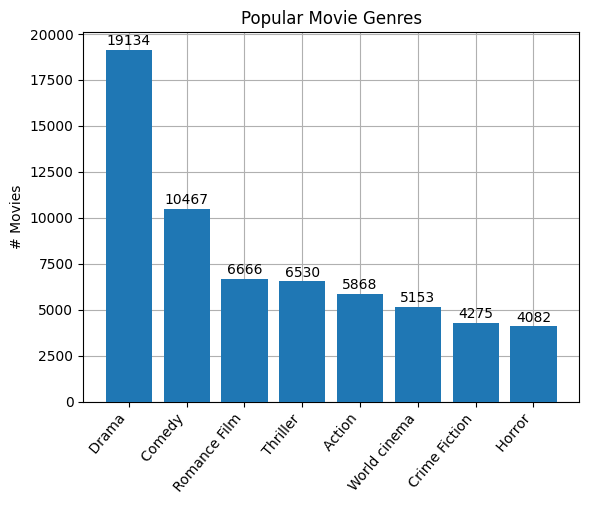

In [ ]:
print_movie_statistics(df)
plot_genre_counts(df)

## Stop words

Stop words are common words that are excluded from text processing tasks. They are considered insignificant because they are frequently used and do nott carry much meaning. Some examples of stop words in English include: "the", "and", "is", "a" and "an".

In [ ]:
def find_numeric_words(df):
    """
    Finds the words that include numeric characters.
    """
    numeric_words = set()
    for plot in df["plot_summary"]:
        words = plot.split()
        for word in words:
            if any(char.isdigit() for char in word):
                numeric_words.add(word)
    return list(numeric_words)

In [ ]:
std_stopwords = list(stopwords.words("english"))
numeric_words = find_numeric_words(df)
all_names = names.words()
irrelevant_words = ["plot", "movie", "film", "director", "several", "many"]
custom_stopwords = std_stopwords + numeric_words + all_names + irrelevant_words

## Content-based Recommendations Using Cosine Similarity

Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. In our case, it can be used to measure similarity in plot summaries.

In [ ]:
tmp_vectorizer_A = TfidfVectorizer(stop_words=[], max_features=None)
tfidf_matrix = tmp_vectorizer_A.fit_transform(df["plot_summary"])
print(len(tmp_vectorizer_A.get_feature_names_out()))

In [ ]:
tmp_vectorizer_B = TfidfVectorizer(stop_words=custom_stopwords, max_features=None)
tfidf_matrix = tmp_vectorizer_B.fit_transform(df["plot_summary"])
print(len(tmp_vectorizer_B.get_feature_names_out()))

In [ ]:
def recommend_movies(df, target_movie_idx, stopwords_lst=[], p=50, flag=True, top_n=5):
    """
    Recommends movies for a given target movie based on the cosine similarity.
    """
    MAX_FT = 141038 if len(stopwords_lst) != 0 else 142364

    # adjusting max_features based on given number of features or percentage
    max_features = p
    if flag:
        max_features = int(MAX_FT * (p / 100))

    # initializing TfidfVectorizer with the given max_features and stopwords
    vectorizer = TfidfVectorizer(stop_words=stopwords_lst, max_features=max_features)

    # fitting and transform the plot summaries
    tfidf_matrix = vectorizer.fit_transform(df["plot_summary"])

    # calculating cosine similarity for the target movie
    cosine_sim = cosine_similarity(tfidf_matrix[target_movie_idx], tfidf_matrix).flatten()

    # getting indices of the most similar movies (excluding the target movie itself)
    similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]

    # printing recommendations with similarity scores
    print(f"Target Movie ID: {target_movie_idx}")
    print(f"Target Movie Title: {df['movie_title'].iloc[target_movie_idx]}")
    print(f"Target Movie Summary: {df['plot_summary'].iloc[target_movie_idx]}")
    print(f"Target Movie Categories: {df['genres'].iloc[target_movie_idx]}\n")
    for i, idx in enumerate(similar_indices):
        print(f"Recommendation {i+1}:")
        print(f"Title: {df['movie_title'].iloc[idx]}")
        print(f"Summary: {df['plot_summary'].iloc[idx]}")
        print(f"Categories: {df['genres'].iloc[idx]}")
        print(f"Similarity Score: {cosine_sim[idx]:.4f}\n")

    # returning the top similarity score
    return cosine_sim[similar_indices[0]]

In [ ]:
def analyze_similarity_vs_max_features(df, stopwords_lst, mf_values, flag, n_target_movies=3):
    """
    Performs analysis on the top similarity score against the number of max features.
    """
    # randomly selecting two target movies
    random_indices = random.sample(range(len(df)), n_target_movies)

    # storing results for both movies
    movie_results = {}
    for i in range(n_target_movies):
        movie_results[random_indices[i]] = {"with_stopwords": [], "without_stopwords": []}

    for max_features_val in mf_values:
        print(f"-----------------------------------------------------")
        if flag:
            print(f"---------- Max features: {max_features_val}% ----------")
        else:
            print(f"---------- Max features: {max_features_val} ----------")
        # with stopwords
        print(f"Removing stopwords ...\n")
        for movie_idx in random_indices:
            top_score_with = recommend_movies(df, movie_idx, stopwords_lst,max_features_val,flag)
            movie_results[movie_idx]["with_stopwords"].append(top_score_with)

        # without stopwords (empty list)
        print(f"Including stopwords ...\n")
        for movie_idx in random_indices:
            top_score_without = recommend_movies(df, movie_idx, [], max_features_val, flag)
            movie_results[movie_idx]["without_stopwords"].append(top_score_without)

    return movie_results

In [ ]:
feature_values = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90]
contains_perc = True

In [ ]:
res = analyze_similarity_vs_max_features(df, custom_stopwords, feature_values, contains_perc)

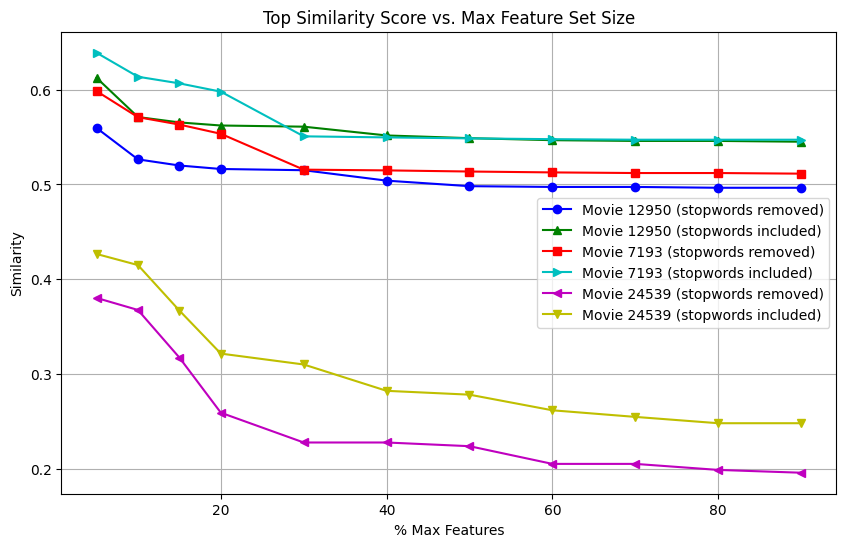

In [ ]:
sim_scores = []
labels = []
for key, value in res.items():
    sim_scores.append(value["with_stopwords"])
    labels.append(f'Movie {key} (stopwords removed)')
    sim_scores.append(value["without_stopwords"])
    labels.append(f'Movie {key} (stopwords included)')

simpleplot(sim_scores,
           feature_values,
           labels,
           "% Max Features",
           "Similarity",
           "Top Similarity Score vs. Max Feature Set Size")

We observe the following:

* As the number of max features increases, the top similarity score decreases (until it converges). When we increase the number of *max_features* in a TF-IDF vectorizer, we are allowing more words (including less relevant or more generic words) to be considered in the document-term matrix. Initially, only the most important and distinctive words are used to calculate the similarity (with low *max_features*), but as the number of features increases, more common and less informative words are included. This dilutes the effect of the distinctive words, causing the overall cosine similarity score between two movies to decrease. At some point, as we keep increasing *max_features*, the additional words become increasingly insignificant and the similarity score converges to a stable value. This is because we are nearing the limit of informative features that can meaningfully contribute to distinguishing the movies. The similarity score becomes relatively stable as we approach using all possible features.

* The top similarity score is higher when we do not exclude the stopwords compared to when we exclude stopwords. Stopwords are common words that are filtered out because they tend to have little meaningful value in distinguishing between texts (e.g. "the", "and", "is"). When we include stopwords in our analysis (i.e. not remove them ), these common words contribute to the document vectors and may artificially increase the similarity between movies, as many movies will share these generic words. On the other hand, when stopwords are removed, the vectorizer focuses more on meaningful and distinctive words, which might lead to lower similarity scores as common words no longer contribute to inflating the similarity. In other words, stopwords can artificially boost the similarity. When stopwords are included, the TF-IDF matrix will have non-zero values for many terms that do not contribute much to the actual content of the plots. This creates higher similarity scores across many movie plots, even when they may not be genuinely similar. When we remove stopwords, the similarity scores become more reflective of actual content-based similarity, as only relevant terms contribute to the score.

Overall, smaller feature sets highlight the most distinctive words that differentiate movie plots. As more features are added, less distinguishing words enter the vector space, causing the similarity score to decrease as noise increases. Additionally, without filtering stopwords, common words inflate the similarity score. These words may appear frequently in multiple plots but do not reflect genuine thematic or content similarity. When we remove stopwords, we are left with more distinctive, content-specific words, leading to a more accurate but lower similarity score. However, it should be noted that when the *max_features* is set too low (e.g. 1% - 5%), the model can often give unreliable results. This is because key distinctive words are missing, general terms dominate the similarity score and the recommendations are skewed by insufficient data points (making it hard to differentiate between movies). To get more stable and meaningful results, it is generally better to use a larger portion of the vocabulary, while still balancing it to avoid too much noise.

In [ ]:
recommend_movies(df, 126, custom_stopwords, 7, True)

## Self-organizing Map (SOM)

A self-organizing map (SOM) is an unsupervised machine learning technique. It is used to produce a low-dimensional (typically two-dimensional) representation of a higher-dimensional data set while preserving the topological structure of the data. This can make high-dimensional data easier to visualize and analyze. While other artificial neural networks employ error-correction learning such as backpropagation with gradient descent, SOM is a type of neural network that is trained using competitive learning. This technique involves a "winner takes all" algorithm. In this process, nodes in a neural network compete to represent an input pattern and only the node with the highest response is updated.

In [ ]:
def get_binary_categories(df):
    """
    Returns the binary representation of the categories along with the relevant mapping.
    """
    catbins = pd.get_dummies(df["genres"].apply(pd.Series).stack()).groupby(level=0).sum().values
    genre_columns = pd.get_dummies(df["genres"].apply(pd.Series).stack()).groupby(level=0).sum().columns
    genre_mapping = {i: genre for i, genre in enumerate(genre_columns)}
    return catbins, genre_columns, genre_mapping


def get_tfidf_matrix(df, stopwords_lst, max_feats=10000):
    """
    Returns a tfidf matrix after fitting.
    """
    # initializing TfidfVectorizer with the given max_features and stopwords
    vectorizer = TfidfVectorizer(stop_words=stopwords_lst, max_features=max_feats)

    # fitting and transform the plot summaries
    tfidf_matrix = vectorizer.fit_transform(df["plot_summary"])

    return tfidf_matrix


def build_mix_dataset(tfidf_matrix, catbins, doc_limit=20000, tf_idf_only=False):
    """
    Combines dense tf_idf and categories to build the final dataset.
    """
    dense_tf_idf = tfidf_matrix.toarray()[:doc_limit]
    if tf_idf_only:
        return dense_tf_idf
    final_set = np.hstack((dense_tf_idf, catbins[:doc_limit]))
    return np.array(final_set, dtype=np.float32)


def data_preprocessing(data, do_pca=False):
    """
    Performs normalization and PCA on the data.
    """
    scaler = StandardScaler()
    pca = PCA(n_components = 2 * min(data.shape[0], data.shape[1]) // 3)
    if do_pca:
        return scaler.fit_transform(pca.fit_transform(data))
    return scaler.fit_transform(data)

In [ ]:
def train_and_visualize_som(df, stopwords_lst, do_pca=False, n_columns=30, n_rows=30):
    """
    Trains and visualizes a SOM after properly processing the input data.
    """
    # encoding the categories
    catbins, genre_columns, genre_mapping = get_binary_categories(df)

    # fitting vectorizer
    tfidf_matrix = get_tfidf_matrix(df, stopwords_lst)

    # processing data
    processed_data = data_preprocessing(build_mix_dataset(tfidf_matrix, catbins), do_pca)

    # SOM training
    som_n_columns = n_columns if n_columns > 0 else 30   # number of columns used in SOM
    som_n_rows = n_rows if n_rows > 0 else 30   # number of rows used in SOM
    som = Somoclu(n_columns=som_n_columns, n_rows=som_n_rows, compactsupport=False)
    som.train(processed_data)

    # U-Matrix visualization
    som.view_umatrix(bestmatches=True, colorbar=True)

    return catbins, genre_columns, genre_mapping, processed_data, som

In [ ]:
def compare_cluster_sizes(cluster_indices):
    """
    Compares the cluster sizes by counting the number of neurons assigned to each cluster.
    """
    # filtering out NoneType values from cluster_indices
    valid_cluster_indices = np.array([idx + 1 for idx in cluster_indices if idx is not None])

    # ensuring cluster_indices are integers
    unique_clusters, counts = np.unique(valid_cluster_indices, return_counts=True)
    unique_clusters = unique_clusters.astype(int)

    # plotting cluster sizes
    barplot(counts, unique_clusters, "# Neurons", "Cluster Sizes")

    return dict(zip(unique_clusters, counts))


def investigate_cluster_content(cluster_indices, genres):
    """
    Investigates cluster content (genres).
    """
    unique_clusters = np.unique(cluster_indices)
    cluster_content = {}

    # iterating through each cluster and count genres
    for cluster_idx in unique_clusters:
        neurons_in_cluster = np.where(cluster_indices == cluster_idx)[0]
        genres_in_cluster = genres[neurons_in_cluster]
        genre_count = Counter(np.argmax(genres_in_cluster, axis=1))

        cluster_content[cluster_idx] = genre_count

    return cluster_content


def plot_top_categories_per_cluster(cluster_content, category_mapping, top_n=12, excluded_n=0):
    """
    Plots the top categories for each cluster, excluding some of the first categories.
    """
    for cluster_idx, counter in cluster_content.items():
        # getting the top categories by count
        top_categories = counter.most_common(top_n + excluded_n)

        # excluding the first exclude_first_n categories
        if len(top_categories) > excluded_n:
            top_categories = top_categories[excluded_n:]
        else:
            print(f"Not enough categories to exclude for cluster {cluster_idx}.")
            continue

        # extracting the indices and their corresponding counts
        category_indices, counts = zip(*top_categories)

        # mapping the indices to the actual category names
        try:
            category_names = [category_mapping[i] for i in category_indices]
        except IndexError as e:
            print(f"IndexError: {e}. Ensure all indices are within the valid range.")
            category_names = ['Unknown' for _ in category_indices]

        # plotting the counts of categories
        barplot(counts,
                category_names,
                title=f"Top {top_n - excluded_n} Categories for Cluster {cluster_idx + 1}")


def classify_neurons(bmu_array, cluster_indices, grid_size):
    """
    Classifies the neurons of the grid based on the clusters.
    """
    clustered_neurons = np.empty(shape=grid_size)
    clustered_neurons.fill(0)
    for i in range(len(bmu_array)):
        # getting the cluster index and BMU coordinates for the current data point
        cluster_idx = cluster_indices[i]
        bmu_coords = bmu_array[i]

        # classifying the neuron based on its cluster
        clustered_neurons[bmu_coords[0]][bmu_coords[1]] = cluster_idx + 1

    return clustered_neurons


def get_similar_movies(movie_idx, cluster_indices, n_recs=5):
    """
    Returns the indexes of the movies to be recommended for a given target movie.
    """
    # finding the cluster index corresponding to the BMU
    target_cluster_idx = cluster_indices[movie_idx]

    # getting movies from the same cluster
    similar_movies = np.where(cluster_indices == target_cluster_idx)[0]

    # excluding the target movie itself
    similar_movies = similar_movies[similar_movies != movie_idx]

    # returning top similar movies
    return similar_movies[:n_recs]


def recommend_movies_with_som(movie_idx, cluster_indices, df):
    """
    Recommends movies for a given target movie using the SOM and the clusters.
    """
    recommended_movies = get_similar_movies(movie_idx, cluster_indices)
    print(f"Target Movie ID: {movie_idx}")
    print(f"Target Movie Title: {df['movie_title'].iloc[movie_idx]}")
    print(f"Target Movie Summary: {df['plot_summary'].iloc[movie_idx]}")
    print(f"Target Movie Categories: {df['genres'].iloc[movie_idx]}\n")
    for i, idx in enumerate(recommended_movies):
        print(f"Recommendation {i+1}:")
        print(f"Title: {df['movie_title'].iloc[idx]}")
        print(f"Summary: {df['plot_summary'].iloc[idx]}")
        print(f"Categories: {df['genres'].iloc[idx]}\n")

In [ ]:
som_n_columns = 30   # number of columns for SOM
som_n_rows = 30   # number of rows for SOM
n_clusters = 10   # number of clusters

In [ ]:
catbins, genre_columns, _, processed_data, som = train_and_visualize_som(df,
                                                                         custom_stopwords,
                                                                         True,
                                                                         som_n_columns,
                                                                         som_n_rows)
genres = catbins[:len(processed_data)]

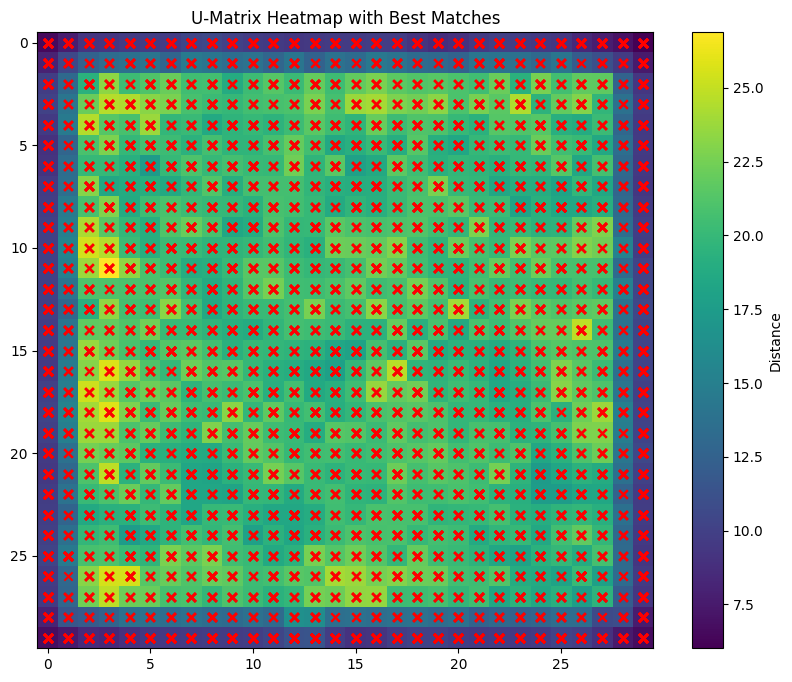

In [ ]:
# enhanced U-Matrix visualization
plot_enhanced_umatrix(som)

In [ ]:
# k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
bmu_array = np.array(som.bmus)
kmeans.fit(bmu_array)

# cluster indices for each BMU
cluster_indices = kmeans.labels_

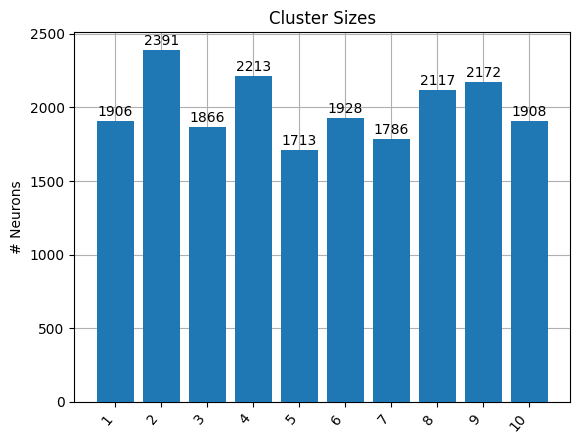

In [ ]:
# comparing cluster sizes
cluster_sizes = compare_cluster_sizes(cluster_indices)

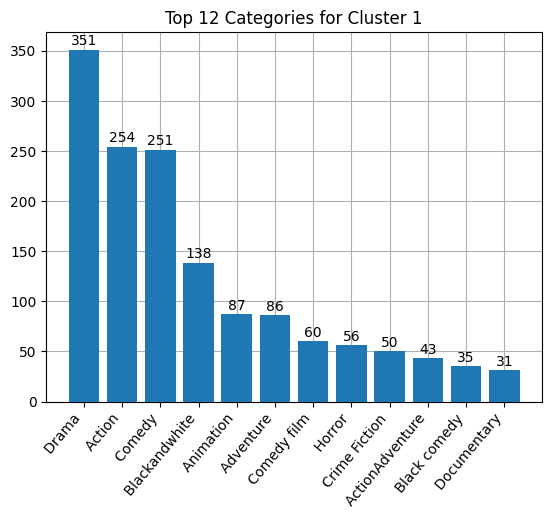

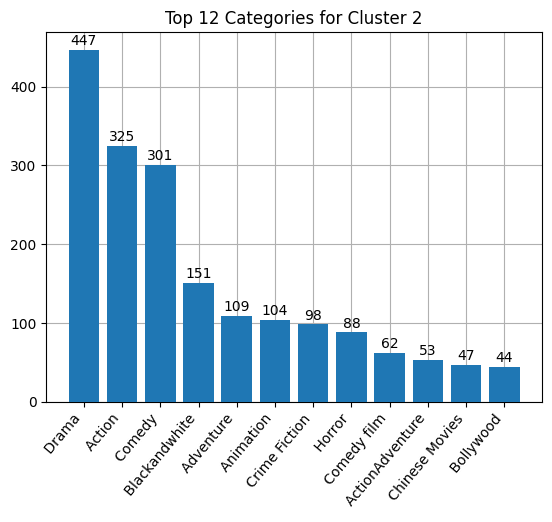

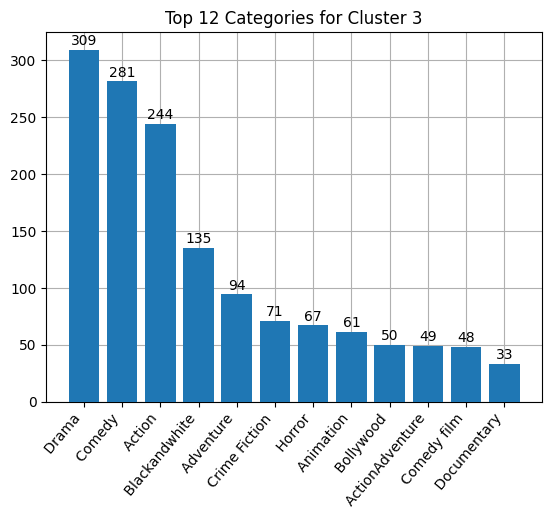

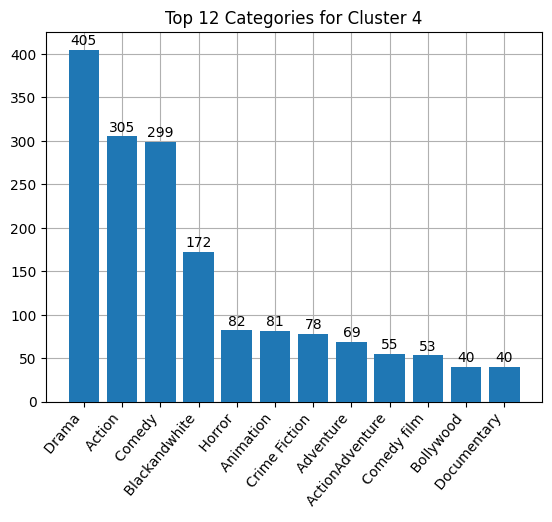

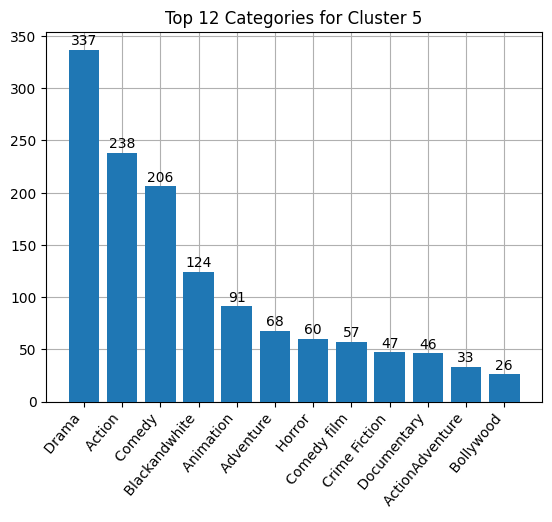

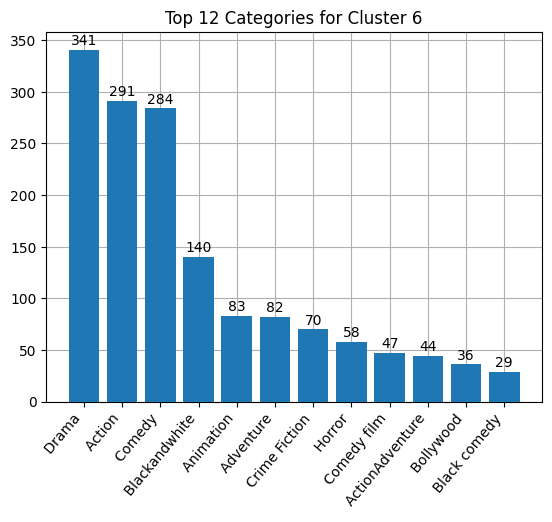

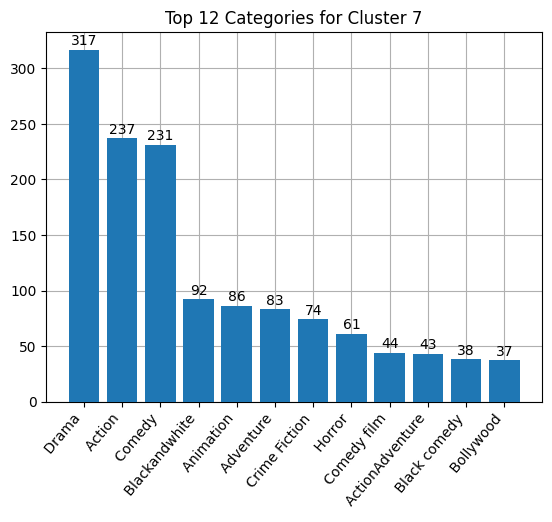

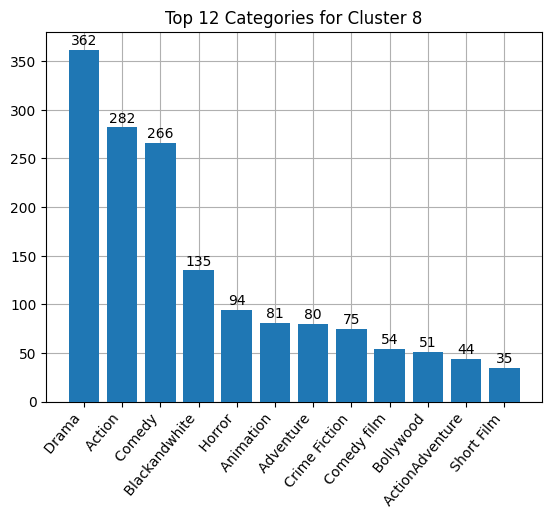

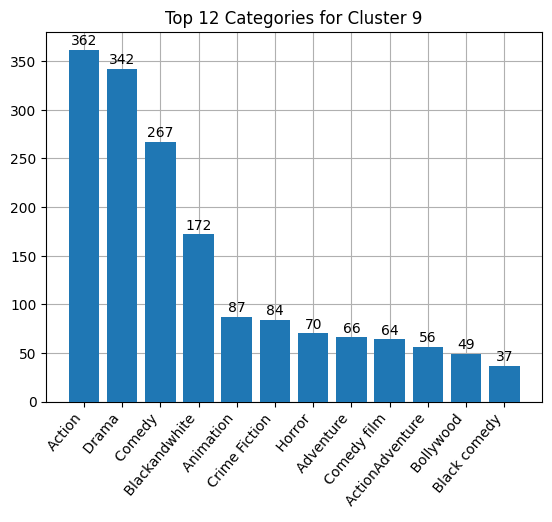

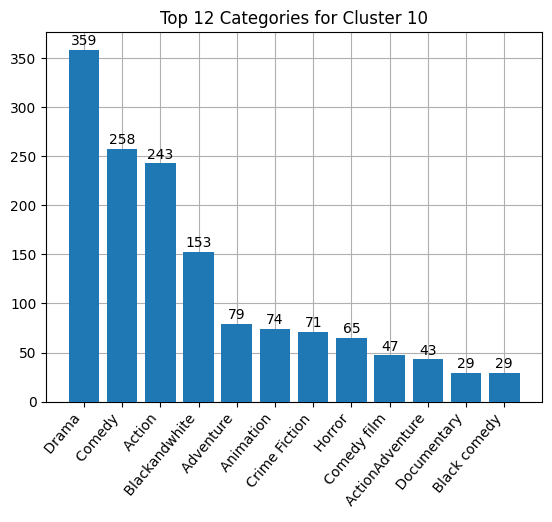

In [ ]:
# investigating cluster content (for genre analysis)
cluster_content = investigate_cluster_content(cluster_indices, genres)
plot_top_categories_per_cluster(cluster_content, genre_columns, 12)

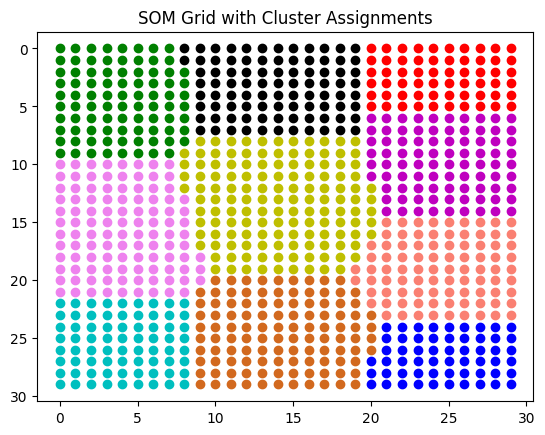

In [ ]:
# classifying the neurons
clustered_neurons = classify_neurons(bmu_array, cluster_indices, (som_n_rows, som_n_columns))

# plotting the clusters of a SOM.
plot_som_clusters(clustered_neurons, (som_n_rows, som_n_columns))

In [ ]:
# recommending options for a target movie
recommend_movies_with_som(1000, cluster_indices, df)

Target Movie ID: 1000
Target Movie Title: Uncorked
Target Movie Summary: Johnny  is a high-powered executive who is definitely not looking to fall in love but a business conference takes her to wine country she meets a handsome widower Andrew  who invites Johnny to meet his family after she loses her job. In helping his parents' winery she begins to fall in love with him and his family but when she gets offered another job she has to choose between her career or Andrew.
Target Movie Categories: [' Romance Film']

Recommendation 1:
Title: Henry V
Summary: {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally negotiations are made for Henry to be named king of both England and France. He has a brief romantic interlude with Catherine while the French and English royal delegations negotiate the Treaty of Troyes. The Greek chorus informs the audience that an English-French union lasted as long as Henry V lived and was only lost under his successor Henry VI.
Categories: [' Costume drama', ' War film'

In the first scenario above we have grid size 30x30 with PCA. We observe that the SOM heatmap is uniformly red over a large portion. This suggests that movies are distributed relatively evenly across the neurons. The use of PCA reduces the data's dimensionality, possibly leading to smoother and more compact clusters. Uniform redness indicates that the SOM is mapping the data well with minimal variance between clusters. Therefore, a more evenly distributed map might make it easier to recommend diverse movies, as movies are mapped across more neurons, allowing for smoother neighborhood relationships.

In [ ]:
som_n_columns = 10   # number of columns for SOM
som_n_rows = 10   # number of rows for SOM
n_clusters = 7   # number of clusters

In [ ]:
catbins, genre_columns, _, processed_data, som = train_and_visualize_som(df,
                                                                         custom_stopwords,
                                                                         False,
                                                                         som_n_columns,
                                                                         som_n_rows)
genres = catbins[:len(processed_data)]

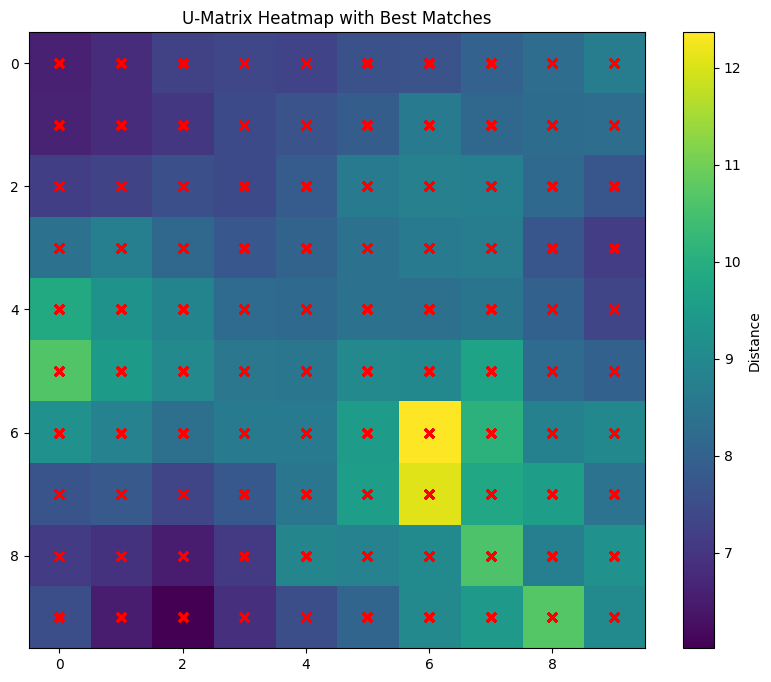

In [ ]:
# enhanced U-Matrix visualization
plot_enhanced_umatrix(som)

In [ ]:
# k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
bmu_array = np.array(som.bmus)
kmeans.fit(bmu_array)

# cluster indices for each BMU
cluster_indices = kmeans.labels_

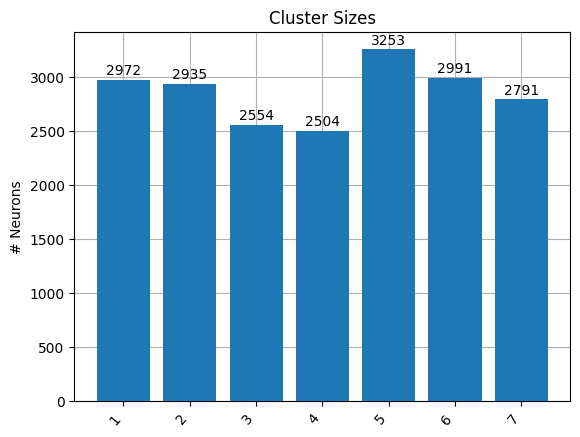

In [ ]:
# comparing cluster sizes
cluster_sizes = compare_cluster_sizes(cluster_indices)

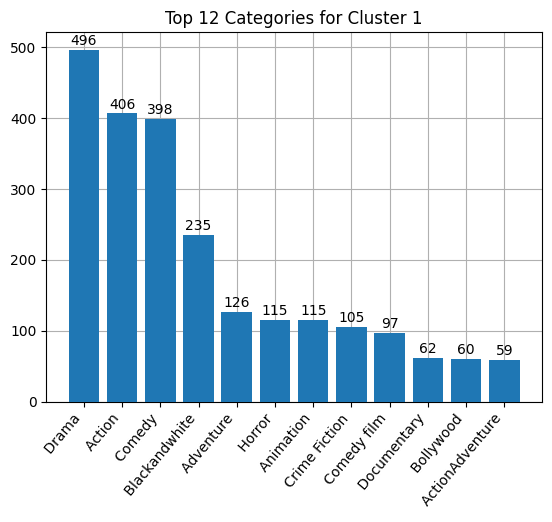

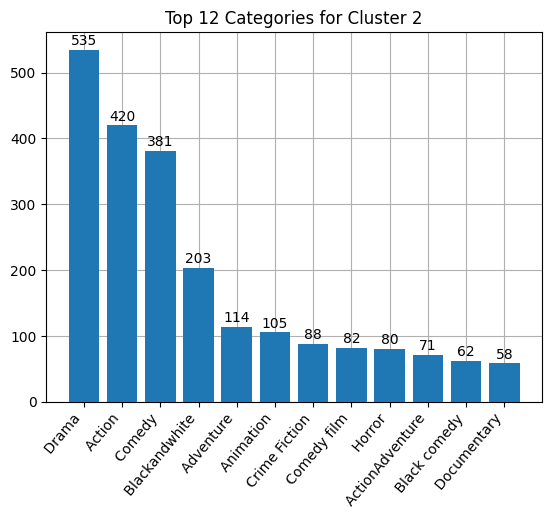

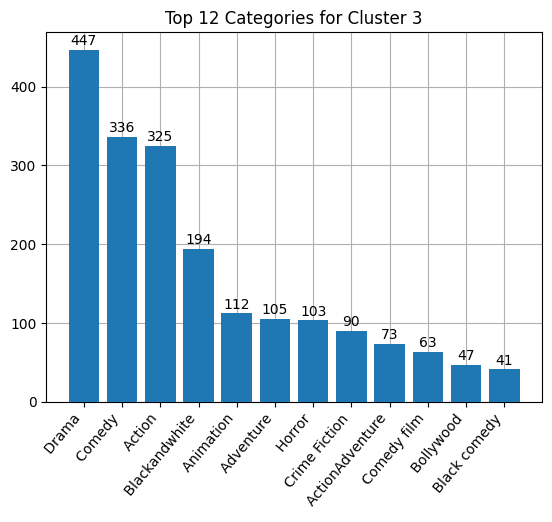

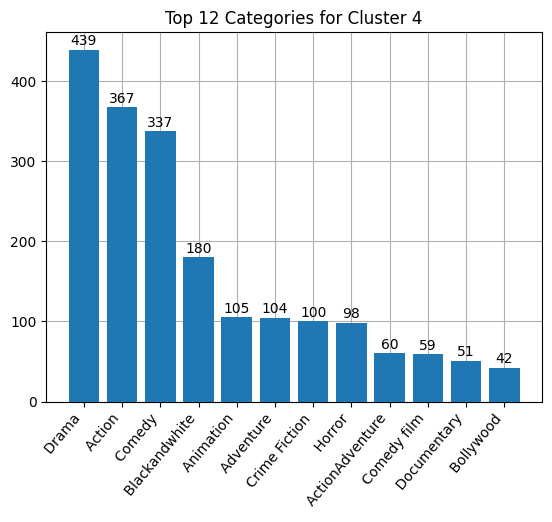

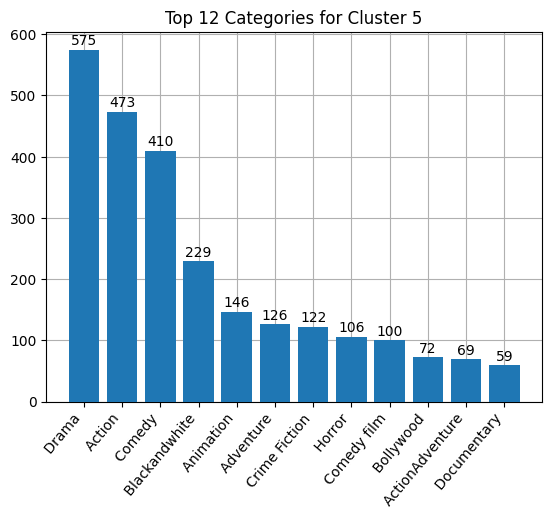

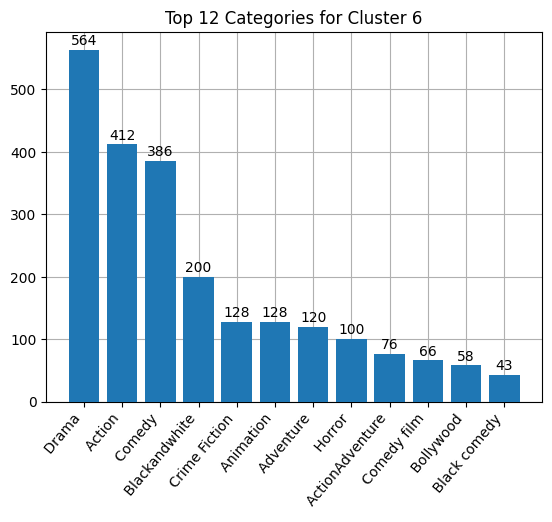

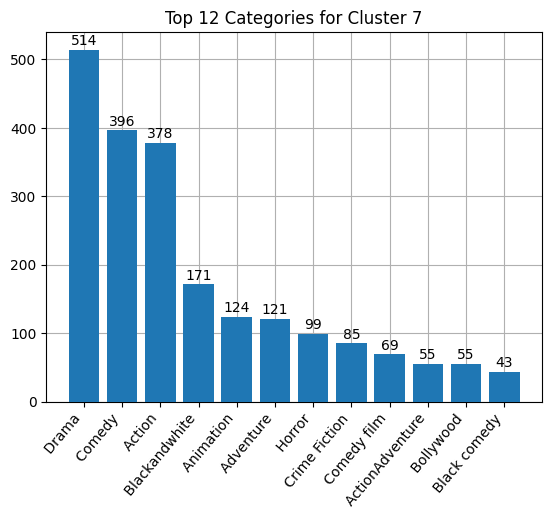

In [ ]:
# investigating cluster content (for genre analysis)
cluster_content = investigate_cluster_content(cluster_indices, genres)
plot_top_categories_per_cluster(cluster_content, genre_columns, 12)

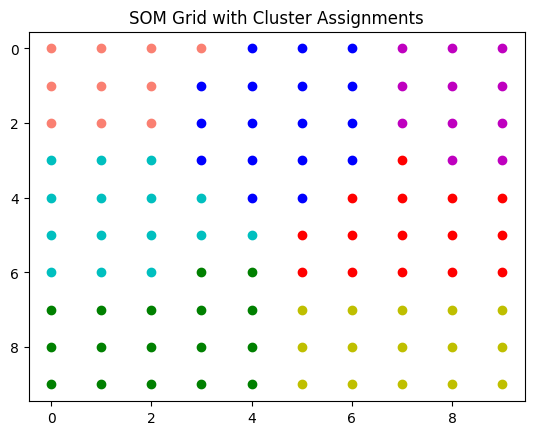

In [ ]:
# classifying the neurons
clustered_neurons = classify_neurons(bmu_array, cluster_indices, (som_n_rows, som_n_columns))

# plotting the clusters of a SOM.
plot_som_clusters(clustered_neurons, (som_n_rows, som_n_columns))

In [ ]:
# recommending options for a target movie
recommend_movies_with_som(1000, cluster_indices, df)

Target Movie ID: 1000
Target Movie Title: Uncorked
Target Movie Summary: Johnny  is a high-powered executive who is definitely not looking to fall in love but a business conference takes her to wine country she meets a handsome widower Andrew  who invites Johnny to meet his family after she loses her job. In helping his parents' winery she begins to fall in love with him and his family but when she gets offered another job she has to choose between her career or Andrew.
Target Movie Categories: [' Romance Film']

Recommendation 1:
Title: Siam Sunset
Summary: Perry is an English chemist working for a paint company and is depressed after losing his wife in a freak accident. As he tries to invent the new color Siam Sunset, he wins a prize, takes leave, and travels to Australia. Grace , on the same tour bus, also has a troubled life. Together they hope to color the world with love rather than paint, but will the universe let them?Siam Sunset at Turner Classic Movies
Categories: [' Romantic

In the second scenario above we have grid size 10x10 without PCA. We observe that the SOM heatmap has a very small and intensely red region, because the small grid size is too restrictive and without dimensionality reduction the movies are concentrated in a small section of the map. This suggests that the SOM might be struggling to separate distinct movie clusters, leading to poor data representation where many movies are grouped into a small set of neurons. This would likely lead to poor recommendations since many movies would be mapped to the same neurons, reducing the ability of the SOM to distinguish between diverse genres or movie types.

In [ ]:
som_n_columns = 30   # number of columns for SOM
som_n_rows = 30   # number of rows for SOM
n_clusters = 10   # number of clusters

In [ ]:
catbins, genre_columns, _, processed_data, som = train_and_visualize_som(df,
                                                                         custom_stopwords,
                                                                         False,
                                                                         som_n_columns,
                                                                         som_n_rows)
genres = catbins[:len(processed_data)]

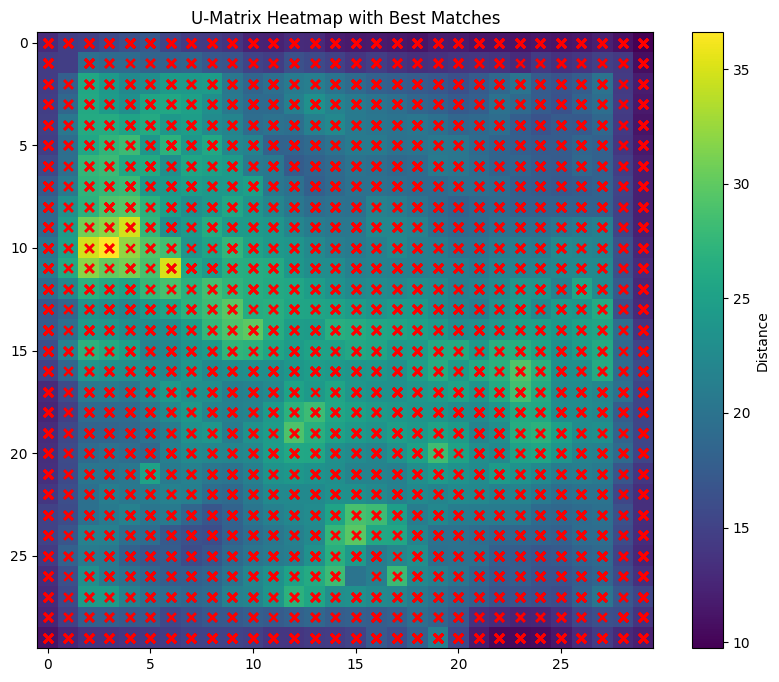

In [ ]:
# enhanced U-Matrix visualization
plot_enhanced_umatrix(som)

In [ ]:
# k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
bmu_array = np.array(som.bmus)
kmeans.fit(bmu_array)

# cluster indices for each BMU
cluster_indices = kmeans.labels_

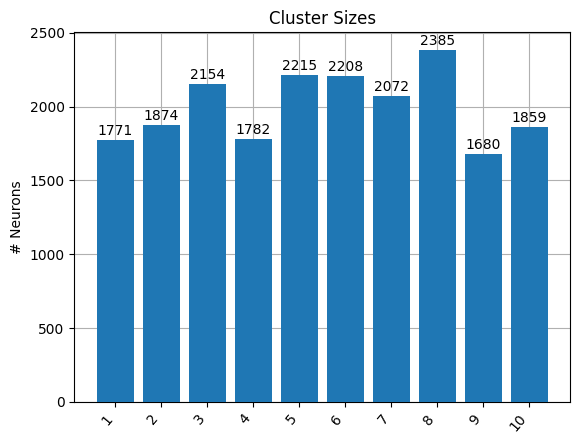

In [ ]:
# comparing cluster sizes
cluster_sizes = compare_cluster_sizes(cluster_indices)

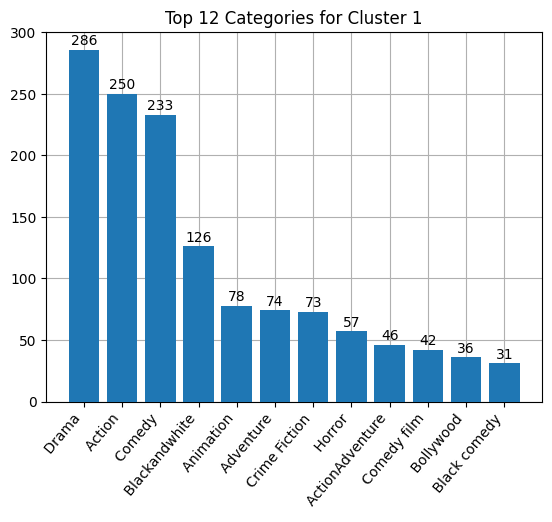

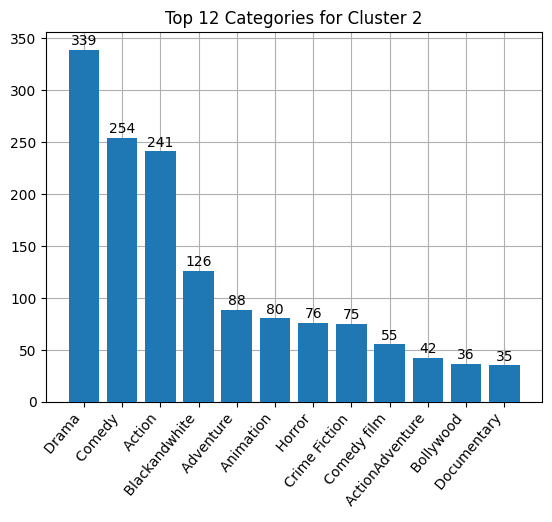

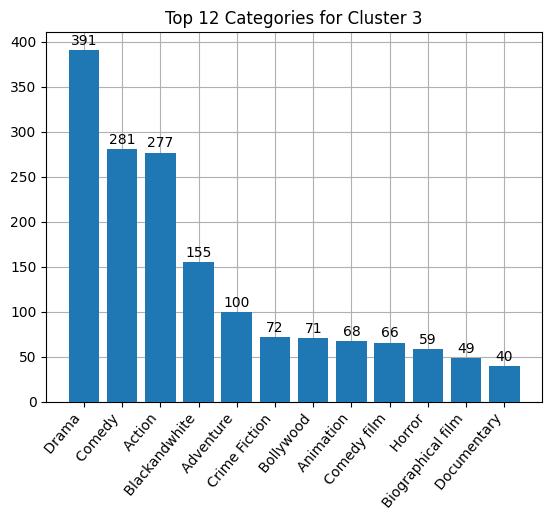

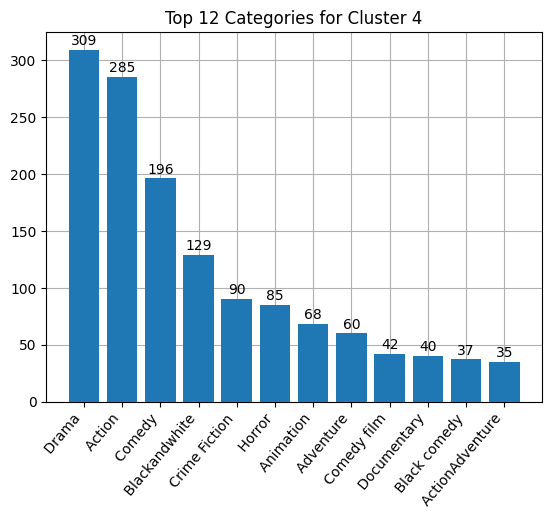

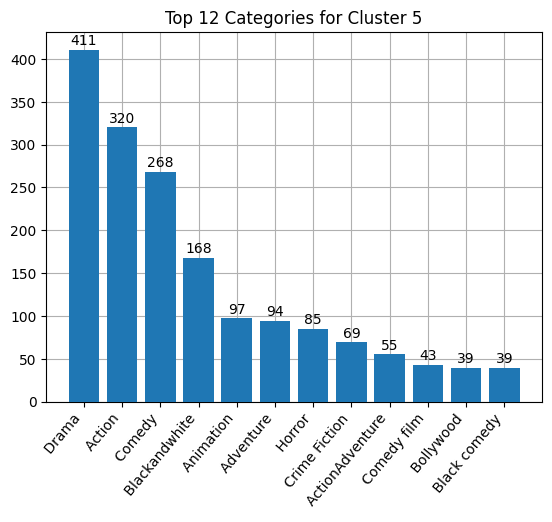

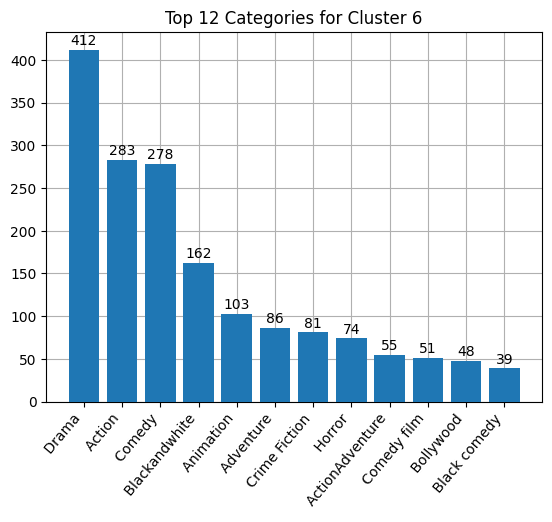

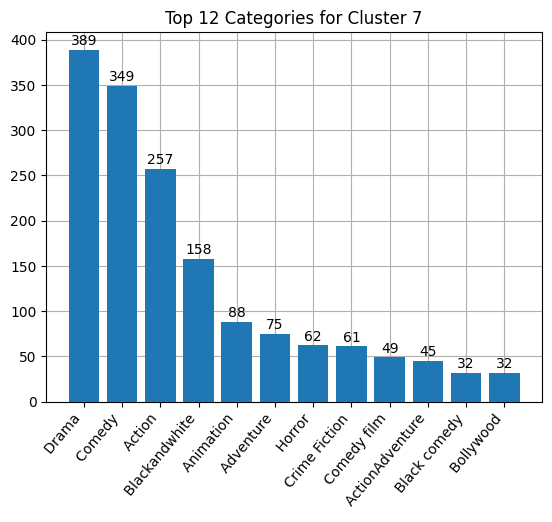

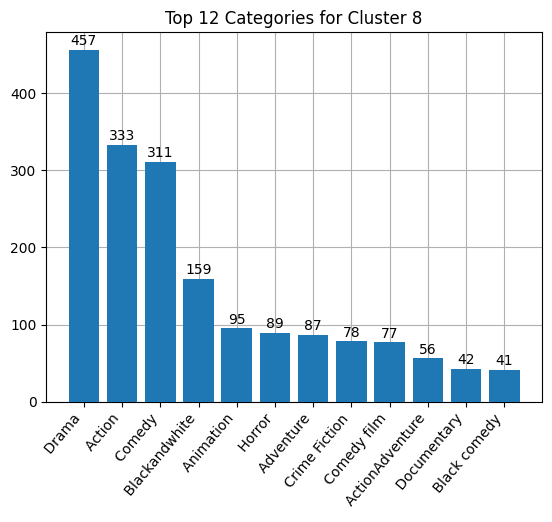

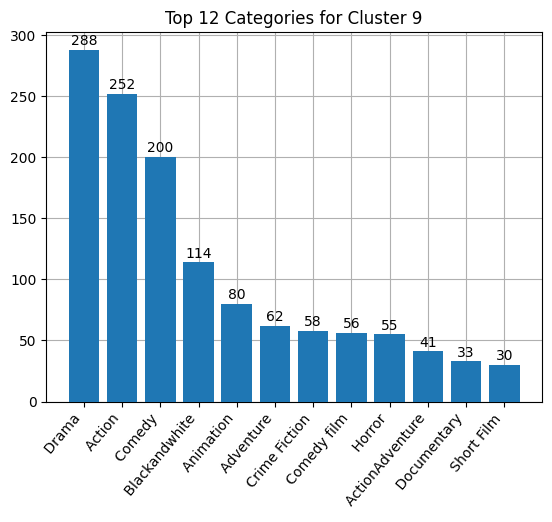

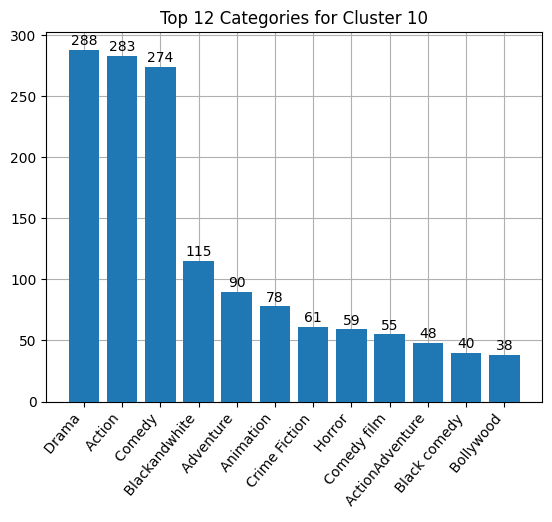

In [ ]:
# investigating cluster content (for genre analysis)
cluster_content = investigate_cluster_content(cluster_indices, genres)
plot_top_categories_per_cluster(cluster_content, genre_columns, 12)

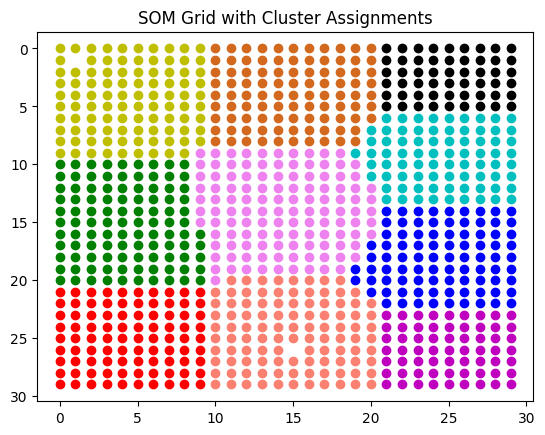

In [ ]:
# classifying the neurons
clustered_neurons = classify_neurons(bmu_array, cluster_indices, (som_n_rows, som_n_columns))

# plotting the clusters of a SOM.
plot_som_clusters(clustered_neurons, (som_n_rows, som_n_columns))

In [ ]:
# recommending options for a target movie
recommend_movies_with_som(1000, cluster_indices, df)

Target Movie ID: 1000
Target Movie Title: Uncorked
Target Movie Summary: Johnny  is a high-powered executive who is definitely not looking to fall in love but a business conference takes her to wine country she meets a handsome widower Andrew  who invites Johnny to meet his family after she loses her job. In helping his parents' winery she begins to fall in love with him and his family but when she gets offered another job she has to choose between her career or Andrew.
Target Movie Categories: [' Romance Film']

Recommendation 1:
Title: White on Rice
Summary: Jimmy ([[Hiroshi Watanabe  loves dinosaurs and sleeps on the top bunk. Unfortunately, Jimmy is 40 and shares that bunk with Bob , his 10-year-old nephew. Freshly divorced, Jimmy lives with his sister Aiko  and her family while boldly searching for a new wife. His brother in-law, Tak  thinks he’s a disaster. And although Jimmy may lack social grace, he is convinced the best years of his life are just beginning. His plan seems like

In the third scenario above we have grid size 30x30 without PCA. We observe that the SOM heatmap shows one red point and a few yellow areas. Increasing the grid size improves data distribution slightly, but without PCA the map still shows some data concentration, indicating that the SOM is not fully distributing the movies evenly. The presence of red points suggests that certain neurons have a higher density of movies, possibly because of high-dimensional input data that overwhelms the map. This setup might lead to better recommendations than the 10x10 grid but still not as effective as when PCA is applied. Recommendations could be skewed toward movies mapped in the dense areas of the SOM.

Overall, from all three scenarios we observe the following:

* <ins>Grid Size and Granularity</ins>: Larger grid sizes provide more neurons, allowing for finer granularity in clustering. This results in more nuanced groupings of movies, which is desirable for a recommendation system. However, the training time increases significantly and if the data is high-dimensional or noisy, the grid may still exhibit areas of concentration, as seen in the third scenario.

* <ins>Dimensionality Reduction (PCA)</ins>: PCA helps by projecting the data into a lower-dimensional space, which can simplify the clustering process and lead to more even distributions across the SOM. When PCA is applied, the SOM shows a more uniform heatmap, indicating better clustering and representation of the movies. Without PCA, high-dimensional data overwhelms the map, leading to concentrated clusters.

## Graph Neural Network (GNN)

A graph neural network (GNN) is used for processing data that can be represented as graphs. Pairwise message passing constitutes the core design element of GNNs, where graph nodes iteratively update their representations by exchanging information with their neighbors. Several GNN architectures have been proposed, which implement different flavors of message passing, such as recursive and convolutional constructive.

In [ ]:
def create_gnn_dataset(df, stopwords_lst, do_pca=False):
    """
    Creates the dataset for the GNN model.
    """
    # encoding the categories
    catbins, _, _ = get_binary_categories(df)

    # fitting vectorizer
    tfidf_matrix = get_tfidf_matrix(df, stopwords_lst)

    # processing data
    processed_data = data_preprocessing(build_mix_dataset(tfidf_matrix, catbins), do_pca)

    # building a similarity graph (using cosine similarity)
    cosine_sim = cosine_similarity(processed_data)

    # creating bidirectional edges based on cosine similarity threshold
    threshold = 0.5
    edge_index = []
    for i in range(cosine_sim.shape[0]):
        for j in range(i+1, cosine_sim.shape[1]):
            if cosine_sim[i, j] > threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])

    edge_index = torch.tensor(edge_index).t().contiguous()

    # converting movie features to tensor
    x = torch.tensor(processed_data, dtype=torch.float)

    # creating a PyTorch Geometric data object
    data = Data(x=x, edge_index=edge_index)

    return data, cosine_sim

In [ ]:
# definition of the GNN model using GCNConv
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


def train_gnn(data, num_epochs=150, hidden_dim=256, lr=0.001):
    """
    Trains the GNN model.
    """
    num_features = data.x.size(1)
    num_classes = data.x.size(1)

    model = GNNModel(num_features, hidden_dim, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.x)   # autoencoder-like loss
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    return model


def recommend_movies_with_gnn(target_movie_idx, df, model, data, num_recommendations=5):
    """
    Recommends movies for a given target movie using the GNN and cosine similarity.
    """
    model.eval()
    with torch.no_grad():
        embeddings = model(data)

    # converting PyTorch tensor to NumPy array for cosine similarity computation
    embeddings_np = embeddings.cpu().numpy()

    # computing cosine similarity between the target movie and all others
    target_embedding = embeddings_np[target_movie_idx].reshape(1, -1)
    similarity_scores = cosine_similarity(target_embedding, embeddings_np).flatten()

    # getting the most similar movies (excluding the target movie itself)
    similar_indices = similarity_scores.argsort()[::-1][1:num_recommendations+1]

    # printing recommendations with similarity scores
    print(f"Target Movie ID: {target_movie_idx}")
    print(f"Target Movie Title: {df['movie_title'].iloc[target_movie_idx]}")
    print(f"Target Movie Summary: {df['plot_summary'].iloc[target_movie_idx]}")
    print(f"Target Movie Categories: {df['genres'].iloc[target_movie_idx]}\n")
    for i, idx in enumerate(similar_indices):
        print(f"Recommendation {i+1}:")
        print(f"Title: {df['movie_title'].iloc[idx]}")
        print(f"Summary: {df['plot_summary'].iloc[idx]}")
        print(f"Categories: {df['genres'].iloc[idx]}")
        print(f"Similarity Score: {similarity_scores[idx]:.4f}\n")

In [ ]:
# data preparation for GNN
data, cosine_sim = create_gnn_dataset(df, custom_stopwords, True)

In [ ]:
# training the GNN model
model = train_gnn(data)

Epoch 10/150, Loss: 0.9997
Epoch 20/150, Loss: 0.9824
Epoch 30/150, Loss: 0.9757
Epoch 40/150, Loss: 0.9717
Epoch 50/150, Loss: 0.9695
Epoch 60/150, Loss: 0.9681
Epoch 70/150, Loss: 0.9673
Epoch 80/150, Loss: 0.9668
Epoch 90/150, Loss: 0.9664
Epoch 100/150, Loss: 0.9661
Epoch 110/150, Loss: 0.9659
Epoch 120/150, Loss: 0.9657
Epoch 130/150, Loss: 0.9655
Epoch 140/150, Loss: 0.9654
Epoch 150/150, Loss: 0.9652


In [ ]:
# recommending options for a target movie
recommend_movies_with_gnn(126, df, model, data)

Target Movie ID: 126
Target Movie Title: Superman
Target Movie Summary: On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glowing g

A GNN was implemented using **Graph Convolutional Network (GCN) layers** for our movie recommendation system.

* First and foremost, the movie dataset is vectorized using TF-IDF and binary encoding for categorical features. A similarity graph is built where movies (nodes) are connected if their cosine similarity exceeds a certain threshold. These connections form edges between movies. The processed movie features and graph structure (edges) are converted into a format suitable for GNNs.

* The model contains two layers of **Graph Convolutional Networks (GCNConv)**. The first layer takes the input features, transforming them into a hidden dimension, and the second layer transforms the hidden dimension into the output (same size as input features). After the first GCN layer, a ReLU activation function is applied to introduce non-linearity.

* Training is done in an autoencoder-like fashion, where the model aims to reconstruct the original input features from the learned latent space. The loss function used is Mean Squared Error (MSE) and Adam optimizer is employed to update the weights. The model is trained over a number of epochs.

* After training, the model produces embeddings for each movie. Recommendations are generated by finding movies whose embeddings are most similar to a target movie using cosine similarity.

We observe the following:

* Decreasing the learning rate can have an impact on training stability. A smaller learning rate allows the model to make more gradual weight updates. This can lead to more stable convergence and prevent overshooting of the optimal weights, which is especially important in GNNs where small changes in the weights affect the global graph structure.

* Increasing the number of epochs led to better results. GNNs often require more training time because information needs to propagate across the graph through multiple layers. More epochs allow the model to iteratively improve the quality of node embeddings, which is essential for clustering similar movies. However, the improvement in performance usually plateaus after a certain point, so increasing epochs beyond a threshold might result in diminishing returns.

* Increasing the hidden layer size gives the model more capacity to learn meaningful representations, especially if PCA is being used. In other words, the hidden dimension defines the representation capacity of the model. A larger hidden size means the model has more room to store complex information, potentially leading to better embeddings of movie features. However, increasing the hidden size too much might lead to overfitting, where the model captures too many details specific to the training data and generalizes poorly to unseen data.

Overall, these changes align with typical GNN behavior, where training stability, information propagation and model capacity are key factors in improving performance.

## Qualitative Analysis

We have tested three distinct models to generate movie recommendations for two target films: *Clean* and *Superman*. We present a qualitative comparison of the recommendations provided by each model based on their approach, and we analyze the thematic relevance of the recommendations.

1. **Content-based Recommendations using Cosine Similarity**
  - Recommendations for target movie *Clean*:
    - Case 39
    - The Face
    - A Yank at Oxford
    - Remember the Night
  - Recommendations for target movie *Superman*:
    - Superman II
    - Superman II: The Richard Donner Cut
    - All-Star Superman
    - Superman: Brainiac Attacks
  - Regarding the first target movie, while some thematic relevance is observed in films like The Face (which also revolves around a troubled female protagonist with emotional scars), the other recommendations like Case 39 (a supernatural thriller) and A Yank at Oxford (a comedy-drama), diverge from Clean's primary themes of personal struggle and redemption. The recommendations here show only superficial similarities (e.g. character names, emotional arcs), which is likely due to reliance on keyword matches in plot summaries.
  - For the second target movie, the content-based approach provides a set of recommendations that are unsurprisingly dominated by Superman sequels or films within the same franchise. While these recommendations are thematically consistent with the target movie, they offer little diversity or novel insight. This is a clear example of a limitation with the content-based method when the target movie belongs to an expansive franchise.
  - This model tends to focus on keywords in the summary and does not deeply understand the emotional or narrative nuances of the target movie, leading to varied and less targeted results.

2. **Hybrid Content-based Recommendations using SOM with K-Means Clustering**
  - Recommendations for target movie *Clean*:
    - Kadosh
    - Nenè
    - Cronaca di un amore
    - Dream Home
  - Recommendations for target movie *Superman*:
    - Deadly Voyage
    - Beachhead
    - Kibera Kid
    - The Big Trees
  - For the first target movie, the recommendations here align more closely with Clean, as films like Kadosh and Cronaca di un amore explore deep emotional struggles within relationships and societal expectations. These films, similar to Clean, tackle heavy themes such as personal turmoil and conflict, suggesting that clustering based on both plot and genres provides a stronger thematic coherence. Dream Home offers a more unusual blend, incorporating horror elements, but still retains the personal, emotional drive of the protagonist, akin to Emily's quest for stability. The use of clustering and genre similarity better captures the overall emotional landscape of Clean.
  - As far as the second target movie is concerned, Deadly Voyage's action-driven narrative aligns with Superman's adventurous spirit, though it lacks the superhero theme. Themes of bravery and camaraderie in Beachhead resonate with the heroic elements of Superman's narrative. However, the theme of redemption in Kibera Kid and the moral struggle over land and greed in The Big Trees diverges from Superman's themes but reflects conflict and resolution.
  - This model provides a better balance of plot and genre similarity, clustering movies in a more meaningful way. Nevertheless, that might lead to some recommended outliers.

3. **Hybrid Content-based Recommendations using Graph Neural Network (GNN) with Cosine Similarity**
  - Recommendations for target movie *Clean*:
    - Critters
    - Flywheel
    - Born to Win
    - ATM
  - Recommendations for target movie *Superman*:
    - Superman II
    - Superman II: The Richard Donner Cut
    - The Arctic Giant
    - The Mechanical Monsters
  - For the first target movie, while the genre may shift (especially in the case of Critters and ATM where the genre leans towards sci-fi and thriller territory respectively), the underlying themes of chaos, addiction, despair, human resilience and redemption can be found both in Clean and the recommended movies.
  - Regarding the second target movie, Superman II and Superman II: The Richard Donner Cut are directly related. The theme of discovery in The Arctic Giant parallels Superman's origin, but the tone shifts towards fantastical elements. The Mechanical Monsters directly aligns with the superhero genre and showcases Superman's iconic battles against evil.
  - This model appears to understand both plot and genre relationships at a deeper level, making it the most effective for nuanced recommendations.

Overall, the content-based model performs well when movies share explicit plot details but struggles with more nuanced connections. The SOM-based model provides a better balance of plot and genre similarity, clustering movies in a more meaningful way. The GNN model outperforms the others by understanding both plot and genre relationships at a deeper level, making it the most effective for nuanced recommendations.